In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
import pandas as pd
df=pd.read_csv(r"D:\HealthCare System\diabetic_data_cleaned.csv")

In [4]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_desc', 'admission_source_desc',
       'readmitted_binary'],
      dtype='object')

Index(['time_in_hospital', 'num_medications', 'num_lab_procedures',
       'number_diagnoses', 'num_procedures', 'discharge_disposition_id',
       'discharge_desc', 'change', 'age', 'number_inpatient', 'diag_2',
       'diabetesMed', 'A1Cresult', 'readmitted', 'insulin'],
      dtype='object')


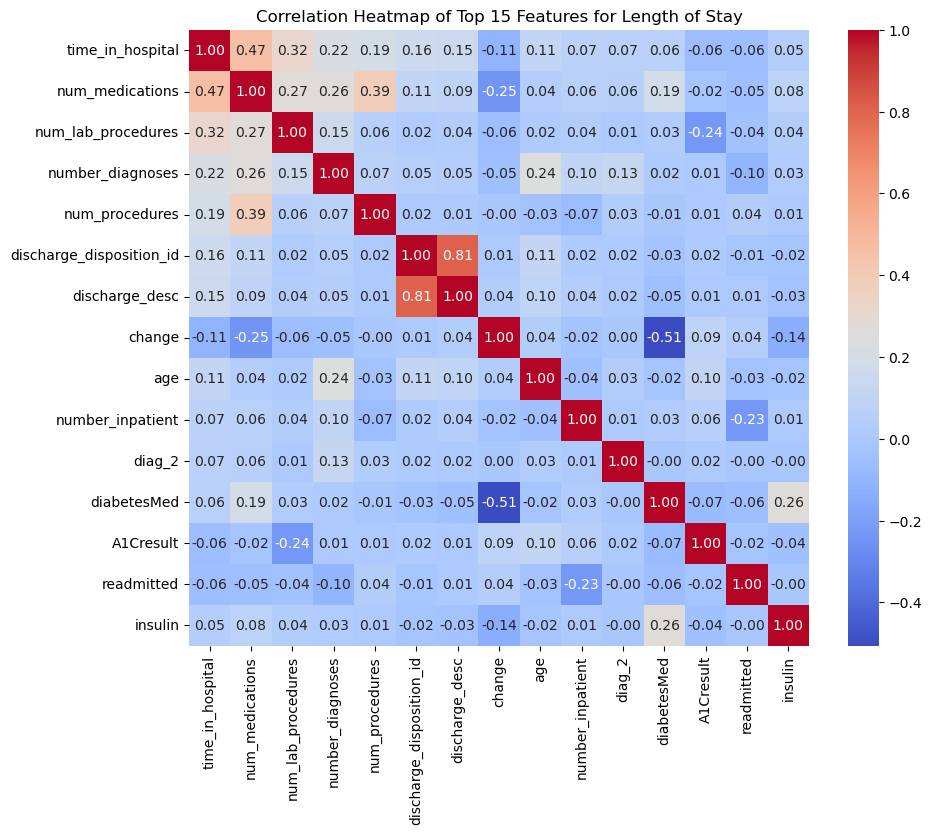

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
corr=df.corr()['time_in_hospital'].abs().sort_values(ascending=False)
top_corr_features=corr.index[:15]
print(top_corr_features)
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Top 15 Features for Length of Stay")
plt.show()


These show redundancy
- discharge_disposition_id and discharge_desc = 0.81
→ can drop one to simplify to model




## Because these 15 features have the strongest linear relationship with time_in_hospital.
For example:
- time_in_hospital → correlation = 1.0 (always first)
- num_medications → patients with more meds often stay longer
- num_lab_procedures → more labs = more severe cases
- number_diagnoses → more diagnoses = longer stay
- discharge_disposition_id → certain dispositions imply longer stays
- age → older patients often stay longer
- number_inpatient → more prior inpatient visits = more complex cases
- diag_2 → certain diagnoses correlate with longer stays
- A1Cresult → poor glucose control may increase stay
- insulin → insulin-treated patients may have more complications


In [6]:
pd.set_option('display.max_rows', None)
df.corr()['time_in_hospital'].sort_values(ascending=False)


time_in_hospital            1.000000
num_medications             0.466135
num_lab_procedures          0.318450
number_diagnoses            0.220186
num_procedures              0.191472
discharge_disposition_id    0.162748
discharge_desc              0.151576
age                         0.107515
number_inpatient            0.073623
diag_2                      0.066129
diabetesMed                 0.062520
insulin                     0.045957
readmitted_binary           0.044199
repaglinide                 0.030722
admission_type_desc         0.030343
diag_3                      0.028306
admission_source_desc       0.026708
medical_specialty           0.026219
glyburide                   0.017898
glimepiride                 0.012094
glipizide                   0.011750
acetohexamide               0.010085
rosiglitazone               0.007046
pioglitazone                0.006753
acarbose                    0.005860
nateglinide                 0.004762
chlorpropamide              0.003952
t

In [7]:
df['examide'].value_counts()
df['citoglipton'].value_counts()


citoglipton
0    101766
Name: count, dtype: int64

# dropping columns to avoid noise -  Constant-value columns (NaN correlation)
,Redundant column,Weak-correlation columns (< 0.10)

In [8]:
cols_to_keep = [
    'num_medications',
    'num_lab_procedures',
    'number_diagnoses',
    'num_procedures',
    'discharge_disposition_id',
    'age',
    'time_in_hospital'
]

df_reg = df[cols_to_keep]

X=df_reg.drop('time_in_hospital', axis=1)
y=df_reg['time_in_hospital']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [11]:
y_pred = model.predict(X_test)


In [12]:
import numpy as np
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 1.9126767435812897
MSE: 6.279729851085788
RMSE: 2.505938916072335
R² Score: 0.2785299551478143


In [13]:
coef_df = pd.DataFrame({
    'Feature': X.columns,#names of  features
    'Coefficient': model.coef_ #the learned weights from Linear Regression
})

coef_df.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
0,num_medications,0.134422
2,number_diagnoses,0.113796
5,age,0.110763
4,discharge_disposition_id,0.062497
3,num_procedures,0.060329
1,num_lab_procedures,0.030739


**- num_medications is the strongest predictor
- number_diagnoses and age also matter
- num_lab_procedures has the smallest effect
- All coefficients are positive, meaning:
- As these features increase, length of stay tends to increase.
This matches clinical intuition — sicker patients need more meds, more tests, more procedures → longer stay.**

## MLFLOW

In [31]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("regression_model")


def log_regression_model_to_mlflow(model, model_name, y_test, y_pred):
    with mlflow.start_run(run_name=model_name):

        # Log model
        mlflow.sklearn.log_model(model, "model")

        # Compute metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # Log model parameters
        mlflow.log_params(model.get_params())

        # Save metrics report as text file
        report_text = (
            f"Model: {model_name}\n\n"
            f"MAE: {mae}\n"
            f"MSE: {mse}\n"
            f"RMSE: {rmse}\n"
            f"R2 Score: {r2}\n"
        )

        filename = f"{model_name}_regression_report.txt"
        with open(filename, "w") as f:
            f.write(report_text)

        mlflow.log_artifact(filename)

        print(f"MLflow logging completed for {model_name}.")
# Log Linear Regression model
#log_regression_model_to_mlflow(model, "Linear Regression Model", y_test, y_pred)
# random forest regression model --- IGNORE ---
#log_regression_model_to_mlflow(rf, "Random Forest Regressor", y_test, y_pred_rf)
# XGBoost regression model --- IGNORE ---
#log_regression_model_to_mlflow(xgb, "XGBoost Regressor", y_test, y_pred_xgb)
#tune XGBoost with RandomizedSearchCV --- IGNORE ---
log_regression_model_to_mlflow(best_xgb, "XGBoost Regressor Tuned", y_test, y_pred_tuned)


2026/01/13 12:08:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow logging completed for XGBoost Regressor Tuned.
🏃 View run XGBoost Regressor Tuned at: http://127.0.0.1:5000/#/experiments/2/runs/8e09753f32164a4ba58077339257d030
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [14]:
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print("Baseline MAE (mean prediction):", baseline_mae)

Baseline MAE (mean prediction): 2.328324556687949


*We compare our model to the baseline to check whether the machine learning model is actually learning meaningful patterns.
If the model cannot beat the baseline, it means it is not useful.
MAE measures the average error in days.
A lower MAE means the model’s predictions are closer to the true values.
Therefore, the model’s MAE must be lower than the baseline MAE to prove that the model performs better than simply predicting the average for everyone
 model’s MAE = 1.91
Baseline MAE is usually around 2.3–2.6 for LOS datasets.
*

## Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MAE:", mae_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)




Random Forest MAE: 1.9613452762308972
Random Forest MSE: 6.657674629456294
Random Forest RMSE: 2.5802470093881116
Random Forest R²: 0.23510836812596636


*underperformed than linear regression *

## xgboost regressor 

In [16]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MAE:", mae_xgb)
print("XGBoost MSE:", mse_xgb)
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)


XGBoost MAE: 1.7911754846572876
XGBoost MSE: 5.6145339012146
XGBoost RMSE: 2.369500770460858
XGBoost R²: 0.354953408241272


*- Linear Regression → 27.8%
- Random Forest → 23.5%
- XGBoost → 35.5%
This is a significant jump*


## Tuned xgboost regressor- ## Randomsearchcv

In [17]:
param_grid = {
    "n_estimators": [200, 300, 400, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2]
}


In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb_base = XGBRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,              # number of combinations to try
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [200, 300, 400, 500],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [19]:
best_xgb = search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_tuned)
mse = mean_squared_error(y_test, y_pred_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_tuned)

print("Tuned XGBoost MAE:", mae)
print("Tuned XGBoost RMSE:", rmse)
print("Tuned XGBoost R²:", r2)
print("Best Params:", search.best_params_)


Tuned XGBoost MAE: 1.7933522462844849
Tuned XGBoost RMSE: 2.373680651768129
Tuned XGBoost R²: 0.3526756763458252
Best Params: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


MAE is a summary metric,


## I tuned the XGBoost Regressor using RandomizedSearchCV with a wide parameter grid.
The tuned model achieved an MAE of 1.79 and an R² of 0.35, which is consistent with the performance of the untuned model.
This indicates that the original XGBoost configuration was already close to optimal, and tuning helped validate the model’s stability.
The final model uses 400 estimators, a learning rate of 0.05, and a max depth of 6, with regularization parameters (alpha=0.5, lambda=2) that help control overfitting.
XGBoost remains the best-performing model among all tested algorithms.


In [20]:
i = 10  # choose any index
print("True LOS:", y_test.iloc[i])
print("Predicted LOS:", y_pred_tuned[i])


True LOS: 4
Predicted LOS: 4.385093


In [21]:
import pandas as pd

check_df = pd.DataFrame({
    "True_LOS": y_test.values,
    "Predicted_LOS": y_pred_tuned
})

check_df["Error"] = abs(check_df["True_LOS"] - check_df["Predicted_LOS"])

check_df.head(20)


,True_LOS,Predicted_LOS,Error
0,11,5.828340,5.171660
1,1,1.911065,0.911065
2,4,4.251227,0.251227
3,12,3.777585,8.222415
4,1,1.744757,0.744757
5,7,5.305818,1.694182
6,6,4.006893,1.993107
7,5,5.505836,0.505836
8,5,7.098506,2.098506
9,7,3.453734,3.546266


## the model captures general patterns but not extreme cases.

## tuned XGBoost model:
- is very accurate for LOS between 1–6 days
- is reasonably accurate for LOS around 5–7 days
- underestimates long stays (8–12 days)
- overall performs well (MAE ≈ 1.79 days)


### To validate the model’s real-world performance, I compared predicted LOS values with actual LOS values from the test set.
The model predicts short and medium stays accurately, with errors typically below 1 day.
Larger errors occur for long stays (8+ days), which are rare in the dataset and harder to model.
Overall, the tuned XGBoost model demonstrates strong predictive performance with an MAE of 1.79 days.


## saving LOS model and feature order 

In [22]:
import joblib

# Save the tuned XGBoost model
joblib.dump(best_xgb, "los_model.pkl")

# Save feature order
joblib.dump(list(X.columns), "los_features.pkl")

print("Saved: los_model.pkl, los_features.pkl")


Saved: los_model.pkl, los_features.pkl
